In [200]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt 
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import  layers
import keras

In [201]:
path = 'D:\ML_data_sql\\2022数模美赛选拔赛\南极洲各地区的数据\\1-91'
try_data = pd.read_excel(os.path.join(path,'all1.xlsx'),engine='openpyxl')
try_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   站点号              275 non-null    int64  
 1   海拔高度(m)          275 non-null    int64  
 2   经度               275 non-null    float64
 3   纬度               275 non-null    float64
 4   年份               275 non-null    int64  
 5   月份               275 non-null    int64  
 6   平均气温(℃)          243 non-null    float64
 7   平均最高气温(℃)        243 non-null    float64
 8   平均最低气温(℃)        243 non-null    float64
 9   最高气温极值(℃)        243 non-null    float64
 10  最低气温极值(℃)        243 non-null    float64
 11  平均气温≥18℃的天数      275 non-null    int64  
 12  平均气温≥35℃的天数      275 non-null    int64  
 13  平均气温≤0℃的天数       275 non-null    int64  
 14  平均露点温度(℃)        134 non-null    float64
 15  降水量(mm)          275 non-null    int64  
 16  最大单日降水量(mm)      243 non-null    float64
 17  降水天数            

1. 首先倒入数据集，对数据集进行一个观察,观察发现有的特征列缺失值太多，有的为0太多，并且无意义，所以酌情筛选一部分特征，并且观察温度，发现有较强的时序性
2. 使用spss软件，导入数据，先使用线性插值的方法将其他列的缺失值补全，然后进行因子分析，使用最大似然法，并进行因子旋转找到影响平均温度的几个因子
3. 发现影响温度的因子有平均气温小于0的天数，平均风速，平均最大持续风速，单日最大平均风速,利用这些特征因子创建LSTM模型进行回归预测
4. 将上述因子和平均气温作为输入导入LSTM模型进行回归训练，导入时为了体现数据的时序性，不进行打乱，并且12个数据为一组，便于训练，总共设计了两个LSTM模型（网络图之后给你）,输出为平均气温，使用前18年的数据进行训练，后两年的数据进行预测，使用MSE Loss 作为损失函数，同时也作为评估指标（把公式图放上去),超参数设置为：训练周期100轮，使用Adam优化器，batch size 为 2，学习率为0.01
5. 在训练后，保存模型开始预测后续的数据


In [202]:
df2= try_data.drop(try_data.columns[[9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,-2,-1]], axis=1)
df2 = df2.fillna(method='pad',axis=1)
# print(np.any(df2.isnull())) 
df2_index = pd.period_range('1997-01',periods=df2.shape[0],freq='M')
df2 = df2.drop(df2.columns[[0,4,5]],axis=1)
df2.index = df2_index
# #数据处理结束
df2.head()

,站点号,海拔高度(m),经度,纬度,年份,月份,平均气温(℃),平均最高气温(℃),平均最低气温(℃),平均气温≤0℃的天数,平均风速(knots),平均最大持续风速(knots),单日最大平均风速(knots)
0,8.927210e+10,1589.0,-71.483333,-74.8,1997.0,1.0,-8.39,-3.00,-13.16,31.0,9.59,17.67,40.8
1,8.927210e+10,1589.0,-71.483333,-74.8,1997.0,2.0,-18.28,-12.20,-23.77,28.0,6.47,11.90,35.0
2,8.927210e+10,1589.0,-71.483333,-74.8,1997.0,3.0,-19.59,-15.11,-24.23,31.0,9.02,16.04,42.0
3,8.927210e+10,1589.0,-71.483333,-74.8,1997.0,4.0,-20.54,-16.67,-24.93,30.0,8.08,14.07,27.0
4,8.927210e+10,1589.0,-71.483333,-74.8,1997.0,5.0,-20.38,-15.92,-25.76,31.0,16.43,25.00,42.9


In [229]:
#归一化处理
from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(df2)
# print(scaled_data)
# scaled_data_series = scaled_data.reshape(1,-1)
# print(scaled_data_series,scaled_data_series.shape)
vis = df2[['平均气温≤0℃的天数','平均风速(knots)','平均最大持续风速(knots)','单日最大平均风速(knots)','平均气温(℃)']].values



In [230]:
vis = vis.reshape(-1,5)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(vis)
# print(scaled_data)
scaled_data_series = scaled_data.reshape(-1,5)
print(scaled_data_series.shape)
# plt.plot(scaled_data)
# plt.show()
print(scaled_data,)

(275, 5)
[[1.         0.22485346 0.31581769 0.42857143 0.55157247]
 [0.90322581 0.15169988 0.2126899  0.36764706 0.33406642]
 [1.         0.21148886 0.28668454 0.44117647 0.30525621]
 ...
 [0.96774194 0.39624853 0.42895442 0.61029412 0.26127117]
 [1.         0.42016413 0.46845398 0.57773109 0.3199912 ]
 [0.29032258 0.36483001 0.41358356 0.44117647 0.40752144]]


In [231]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix][-1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [232]:
print(len(scaled_data_series))

275


In [291]:
raw_seq = scaled_data_series

# choose a number of time steps
n_steps = 48

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# summarize the data
# for i in range(len(X)):
#     print(X[i], y[i])

In [292]:
train_data = X[:-24]
test_data = X[-24:]

train_y = y[:-24]
test_y = y[-24:]

y1 = np.arange(1,train_data.shape[0]+1)
y2 = np.arange(train_data.shape[0],train_data.shape[0]+test_data.shape[0])

# plt.plot(y1, train_data, 'r', y2, test_data, 'b')
# plt.show()

In [293]:
n_features = 5
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], n_features)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], n_features)

In [294]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [295]:
history = model.fit(train_data, train_y, epochs=100, batch_size=2, verbose=2)

Epoch 1/100
102/102 - 1s - loss: 0.0638
Epoch 2/100
102/102 - 2s - loss: 0.0410
Epoch 3/100
102/102 - 1s - loss: 0.0371
Epoch 4/100
102/102 - 1s - loss: 0.0345
Epoch 5/100
102/102 - 1s - loss: 0.0323
Epoch 6/100
102/102 - 1s - loss: 0.0311
Epoch 7/100
102/102 - 1s - loss: 0.0297
Epoch 8/100
102/102 - 1s - loss: 0.0293
Epoch 9/100
102/102 - 1s - loss: 0.0290
Epoch 10/100
102/102 - 1s - loss: 0.0285
Epoch 11/100
102/102 - 1s - loss: 0.0259
Epoch 12/100
102/102 - 1s - loss: 0.0254
Epoch 13/100
102/102 - 1s - loss: 0.0249
Epoch 14/100
102/102 - 1s - loss: 0.0257
Epoch 15/100
102/102 - 1s - loss: 0.0236
Epoch 16/100
102/102 - 1s - loss: 0.0232
Epoch 17/100
102/102 - 1s - loss: 0.0233
Epoch 18/100
102/102 - 1s - loss: 0.0232
Epoch 19/100
102/102 - 1s - loss: 0.0219
Epoch 20/100
102/102 - 1s - loss: 0.0218
Epoch 21/100
102/102 - 1s - loss: 0.0215
Epoch 22/100
102/102 - 1s - loss: 0.0232
Epoch 23/100
102/102 - 1s - loss: 0.0219
Epoch 24/100
102/102 - 1s - loss: 0.0215
Epoch 25/100
102/102 - 1s

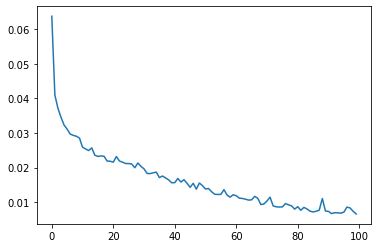

In [296]:
plt.plot(history.history['loss'])
plt.savefig('loss')
plt.show()

In [297]:
loss = model.evaluate(train_data, train_y, verbose=0)
print(loss)

0.004830972757190466


In [298]:
predictions = model.predict(test_data, verbose=2)
train_pre = model.predict(train_data,verbose=2)
predictions = predictions.reshape(predictions.shape[0])
print(predictions.shape, test_y.shape)

1/1 - 0s
7/7 - 0s
(24,) (24,)


In [299]:
show_data = np.hstack((train_y,test_y))
print(len(show_data))
print(train_pre.shape,predictions.shape)
train_pre = train_pre.squeeze()
pre_data = np.hstack((train_pre,predictions))

227
(203, 1) (24,)


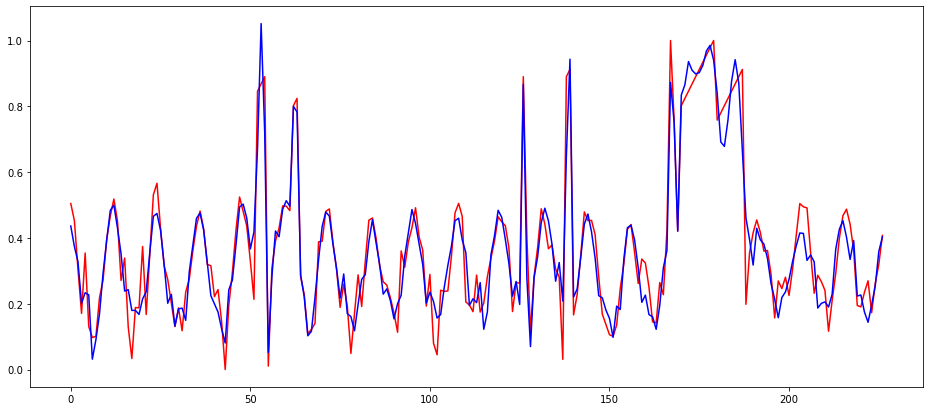

In [302]:
fig = plt.figure(figsize=(16, 7))
plt.plot(range(227), show_data,'r',range(227),pre_data,'b')
# plt.savefig('all1.png')
plt.show()

In [303]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (train_data.shape[1], 5)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [304]:
history2 = regressor.fit(train_data, train_y, epochs=100, batch_size=2, verbose=2)

Epoch 1/200
102/102 - 4s - loss: 0.0648
Epoch 2/200
102/102 - 4s - loss: 0.0513
Epoch 3/200
102/102 - 4s - loss: 0.0528
Epoch 4/200
102/102 - 4s - loss: 0.0419
Epoch 5/200
102/102 - 5s - loss: 0.0440
Epoch 6/200
102/102 - 4s - loss: 0.0415
Epoch 7/200
102/102 - 4s - loss: 0.0433
Epoch 8/200
102/102 - 4s - loss: 0.0416
Epoch 9/200
102/102 - 4s - loss: 0.0411
Epoch 10/200
102/102 - 4s - loss: 0.0358
Epoch 11/200
102/102 - 5s - loss: 0.0349
Epoch 12/200
102/102 - 4s - loss: 0.0345
Epoch 13/200
102/102 - 4s - loss: 0.0355
Epoch 14/200
102/102 - 4s - loss: 0.0347
Epoch 15/200
102/102 - 4s - loss: 0.0343
Epoch 16/200
102/102 - 4s - loss: 0.0356
Epoch 17/200
102/102 - 4s - loss: 0.0321
Epoch 18/200
102/102 - 4s - loss: 0.0333
Epoch 19/200
102/102 - 4s - loss: 0.0297
Epoch 20/200
102/102 - 5s - loss: 0.0352
Epoch 21/200
102/102 - 5s - loss: 0.0318
Epoch 22/200
102/102 - 4s - loss: 0.0315
Epoch 23/200
102/102 - 4s - loss: 0.0327
Epoch 24/200
102/102 - 4s - loss: 0.0316
Epoch 25/200
102/102 - 4s

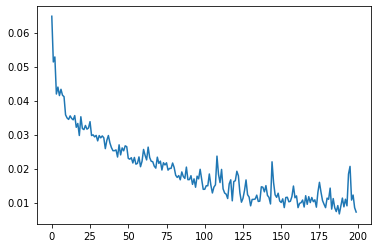

In [306]:
plt.plot(history2.history['loss'])
plt.savefig('loss_big.png')
plt.show()

In [307]:
loss = regressor.evaluate(train_data, train_y, verbose=0)
print(loss)

0.0048959883861243725


In [308]:
predictions2 = regressor.predict(test_data, verbose=2)
train_pre2 = regressor.predict(train_data,verbose=2)
predictions2 = predictions2.reshape(predictions.shape[0])

1/1 - 0s
7/7 - 0s


In [281]:
train_pre2 = train_pre2.squeeze()
pre_data2 = np.hstack((train_pre2,predictions2))

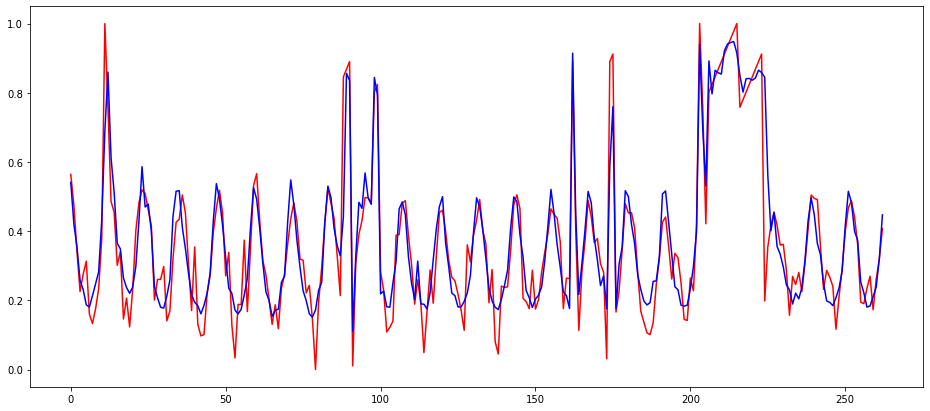

In [282]:
fig = plt.figure(figsize=(16, 7))
plt.plot(range(263), show_data, 'r', range(263), pre_data2, 'b')
plt.show()

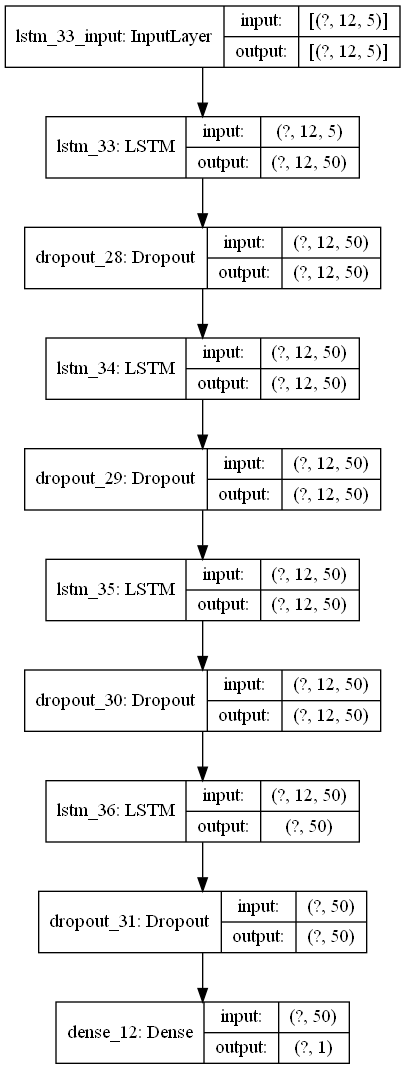

In [285]:
# from keras.utils import plot_model
# plot_model(model, to_file='LSTM_small.png',show_shapes=True)
# plot_model(regressor,to_file='LSTM_big.png',show_shapes=True)

In [310]:
# print(predictions2.shape)
tool = np.ones((24,4))
# test_y = test_y[:,np.newaxis]
# predictions = predictions[:,np.newaxis]
# predictions2 = predictions2[:,np.newaxis]


# print(tool.shape,test_y.shape)
test_y.squeeze()
real = np.concatenate([tool,test_y],axis=1)
pre_real1 =np.concatenate([tool,predictions],axis=1) 
pre_real2 = np.concatenate([tool,predictions2],axis=1)

In [311]:
tool2 = scaler.inverse_transform(real)
tool3 = scaler.inverse_transform(pre_real1)
tool4 = scaler.inverse_transform(pre_real2)
print(tool2[:,-1])
print(tool3[:,-1])
print(tool4[:,-1])


[-10.54 -10.98 -11.14 -17.29 -22.93 -20.44 -21.33 -22.54 -28.18 -23.93
 -20.18 -15.36 -12.21 -11.31 -13.39 -17.02 -24.62 -24.82 -22.79 -21.21
 -25.62 -21.59 -18.92 -14.94]
[-14.60379212 -14.66242102 -18.38549935 -17.6462128  -18.58328602
 -24.9744788  -24.325421   -24.12371196 -24.83129161 -23.06482369
 -16.84563455 -14.10013508 -12.89607506 -15.1738171  -18.2564331
 -15.64894769 -23.3210902  -23.16698217 -25.52982522 -26.9396237
 -24.5597469  -21.93015013 -17.14851554 -15.14338265]
[-15.8607828  -17.21089946 -19.91387958 -22.13104949 -23.7355416
 -24.61638176 -24.85626226 -24.61251223 -23.22962627 -20.42497076
 -16.38682899 -11.41399357 -10.03391133 -14.15248575 -18.36644106
 -22.13976692 -25.63408209 -24.09181602 -16.17272    -16.72886322
 -22.33764642 -23.27169164 -21.18004843 -17.65998886]
